## Business Context
Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.
It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

In [ ]:
!pip install -U scikit-learn imbalanced-learn

In [24]:
# Data manipulation and analysis libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and model evaluation libraries
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    confusion_matrix, roc_auc_score
)
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
)

# Sampling libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Pipeline and transformation libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model building libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
)
from xgboost import XGBClassifier

# Settings to enhance output readability and suppress warnings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)  # Suppress scientific notations in pandas

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")  

In [25]:
train_data = pd.read_csv('/kaggle/input/renewind/Train.csv')
test_data = pd.read_csv('/kaggle/input/renewind/Test.csv')

# Data Overview

In [ ]:
# View top 5 rows of the data
train_data.head()

In [ ]:
# View top 5 rows of the data
test_data.head()

In [ ]:
# Check the dimensions of the data
train_data.shape

In [ ]:
# Check the dimensions of the data
test_data.shape

In [ ]:
# Check data types
train_data.info()

In [ ]:
# Check data types
test_data.info()

In [ ]:
# Double check for null values per column
train_data.isnull().sum()

In [ ]:
# Checking for null values per column
test_data.isnull().sum()

In [ ]:
# Check data duplicate values
train_data.duplicated().sum()

In [ ]:
# Check data duplicate values
test_data.duplicated().sum()

In [ ]:
train_data.describe().T

In [ ]:
test_data.describe().T

In [ ]:
# Check for class distribution of the target variable by looking at the count of observations for each class
class_distribution = train_data['Target'].value_counts(normalize=True) * 100
print(class_distribution)

In [ ]:
# Check for class distribution of the target variable by looking at the count of observations for each class
class_distribution = test_data['Target'].value_counts(normalize=True) * 100
print(class_distribution)

Observations: 

**Dataset Size**:
- The training set contains 20,000 observations, each with 41 columns (40 predictors and 1 target variable).
- The test set includes 5,000 observations, also with 41 columns.

**Data Types**:
- Both datasets primarily consist of numerical features (float64), with the target variable being an integer (int64).

**Missing Values**:
- In the training set, two variables (V1 and V2) have 18 missing values each.
- In the test set, V1 has 5 missing values, and V2 has 6 missing values.
- No missing values are present in the target variable of both datasets.

**Data Integrity**:
- There are no duplicate rows in either the training or the test dataset, indicating good data integrity.

**Class Imbalance**:
Bot training and testing target variables have imbalanced distribution of the target variables classes where:
- About 94% of the observations belong to the negative class (0), which represents "Non-failure" cases.
- About 5% of the observations belong to the positive class (1), representing "Failure" cases.

# Exploratory Data analysis (EDA)

## Univariate Analysis

In [20]:
def hist_and_boxplot(data, variable, figsize=(12, 4), kde=False, bins=None):
    """
    Creates a plot with both a histogram and boxplot for a specified numerical variable.

    Args:
    - data: The DataFrame containing the data.
    - variable: Column name of the numerical variable (feature) to be plotted.
    - figsize: A tuple representing the size of the figure.
    - density_curve: A boolean indicating whether to overlay a density curve curve on the histogram.
    - bins: An integer representing the number of bins for the histogram, or None for automatic bin size.

    Returns:
    None
    """
    # Set up the matplotlib figure with two rows and one column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [0.2, 0.8]})

    # Plot the boxplot on the first row
    sns.boxplot(x=variable, data=data, ax=ax1, showmeans=True, color="lightblue")
    ax1.set(xlabel='', title=f'Boxplot and Distribution of {variable}')

    # Plot the histogram on the second row
    if bins:
        sns.histplot(data[variable], kde=kde, bins=bins, ax=ax2, color="lightblue")
    else:
        sns.histplot(data[variable], kde=kde, ax=ax2, color="lightblue")

 # Draw lines for mean and median
    mean_val = data[variable].mean()
    median_val = data[variable].median()
    ax2.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax2.axvline(median_val, color='black', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    # Add legend to the histogram
    ax2.legend()

    plt.show()

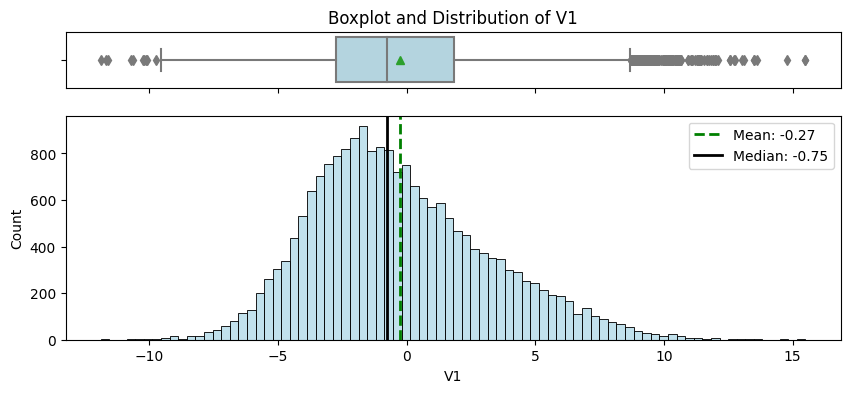

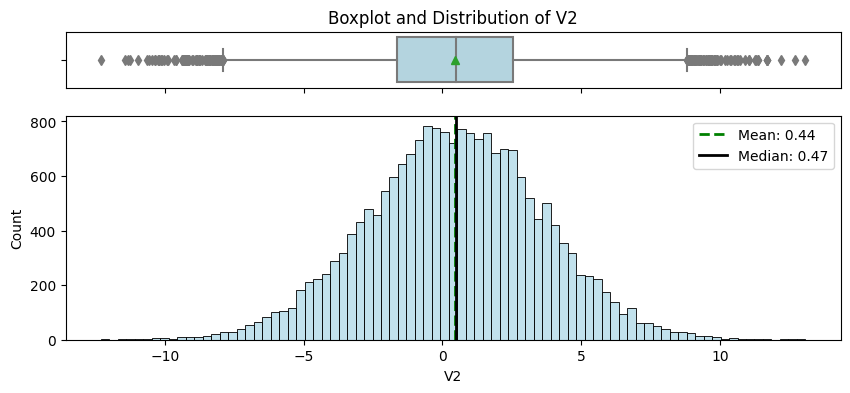

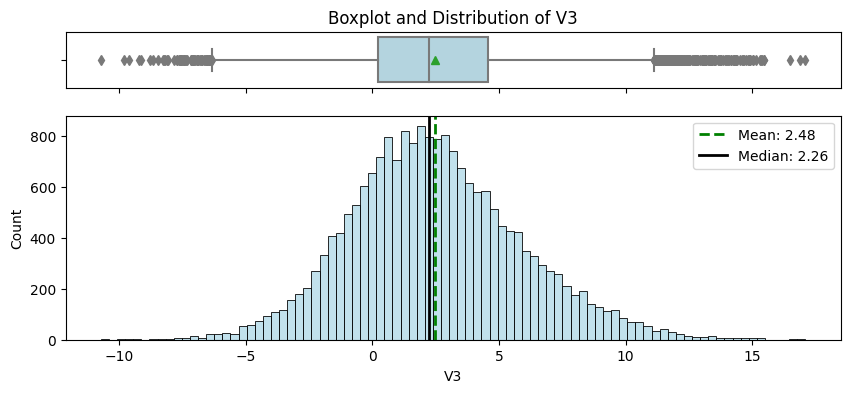

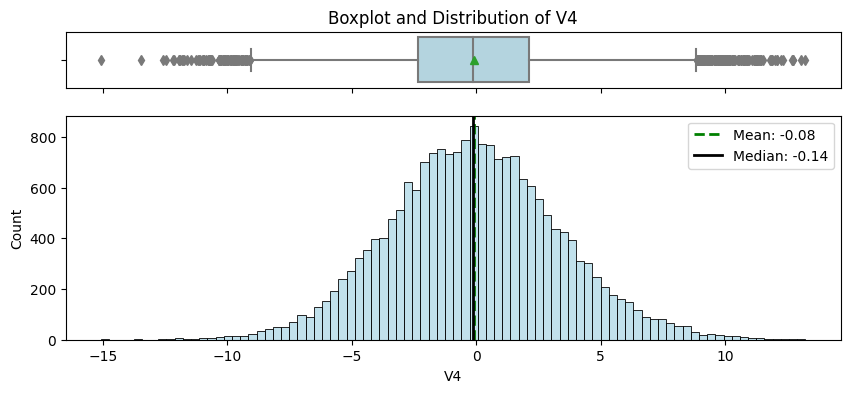

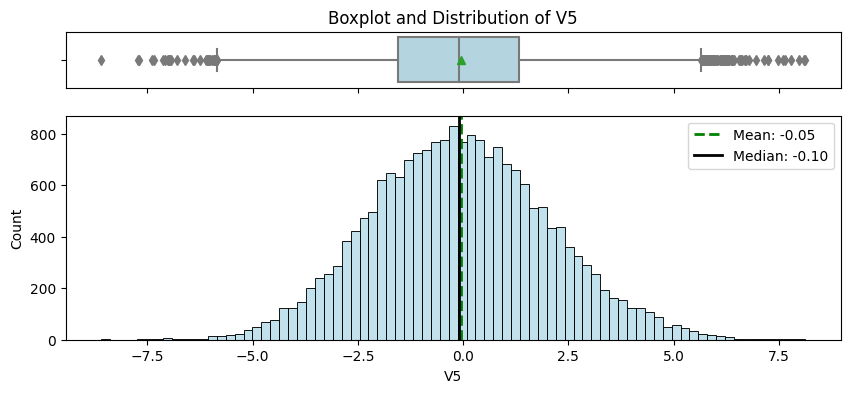

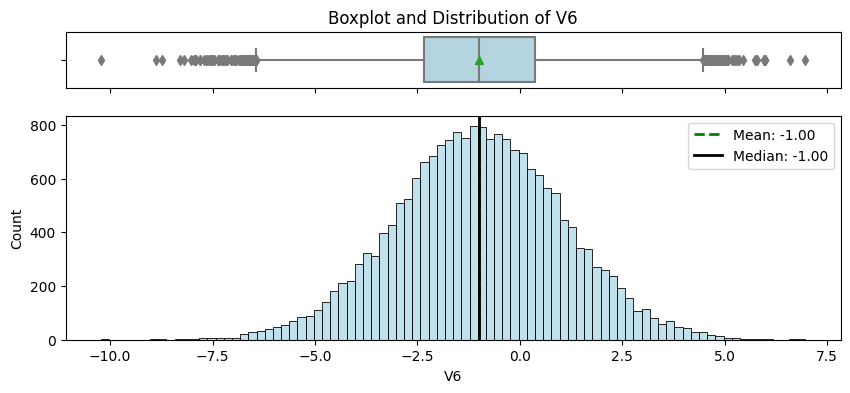

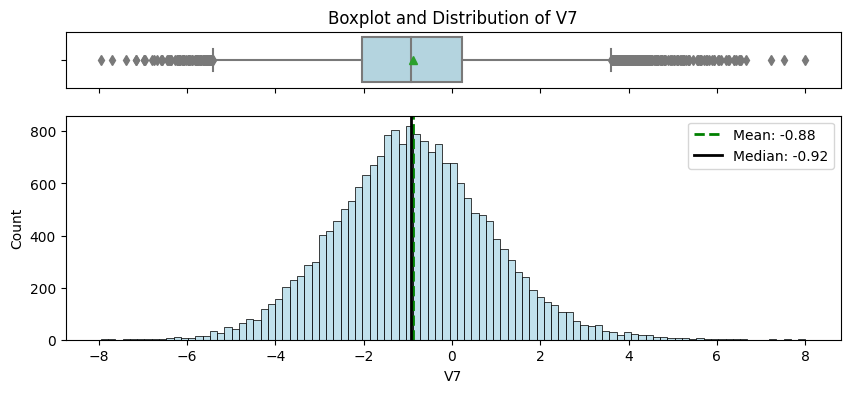

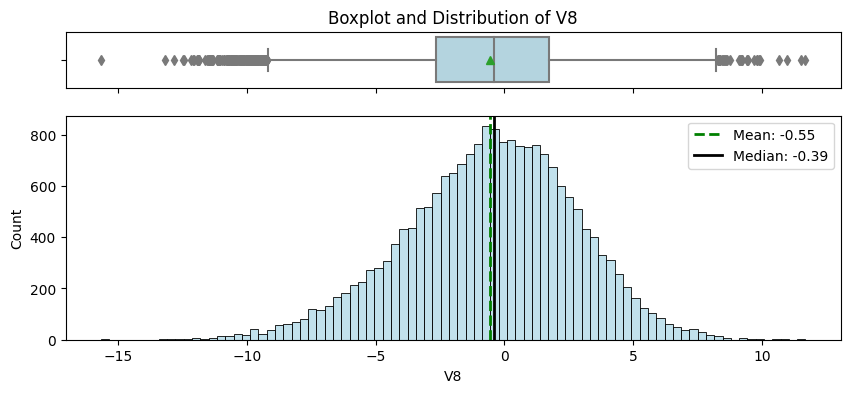

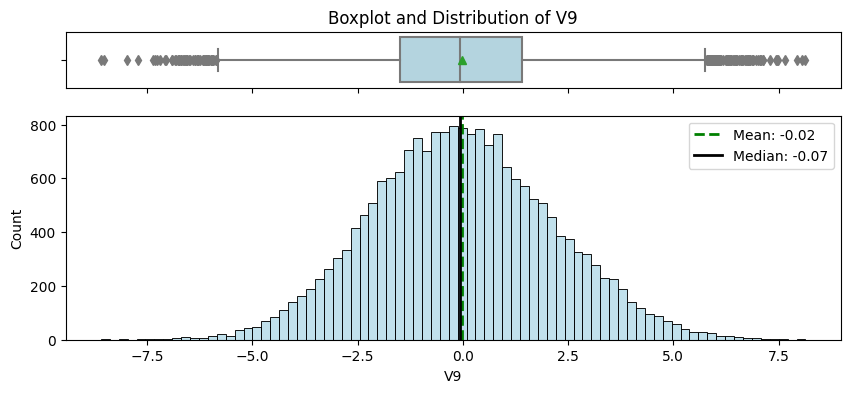

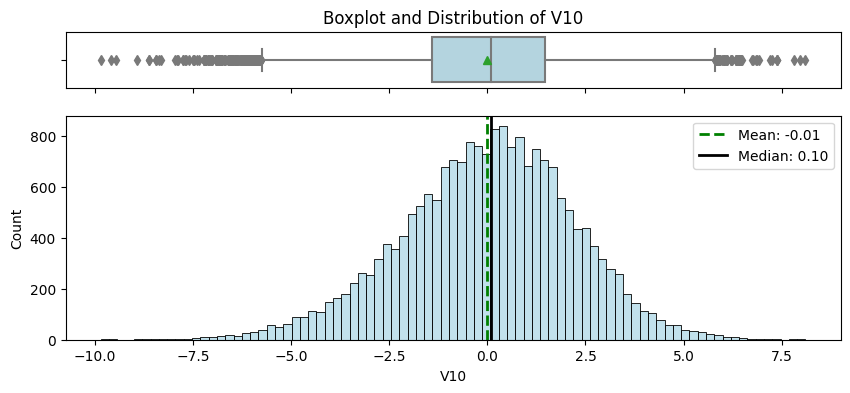

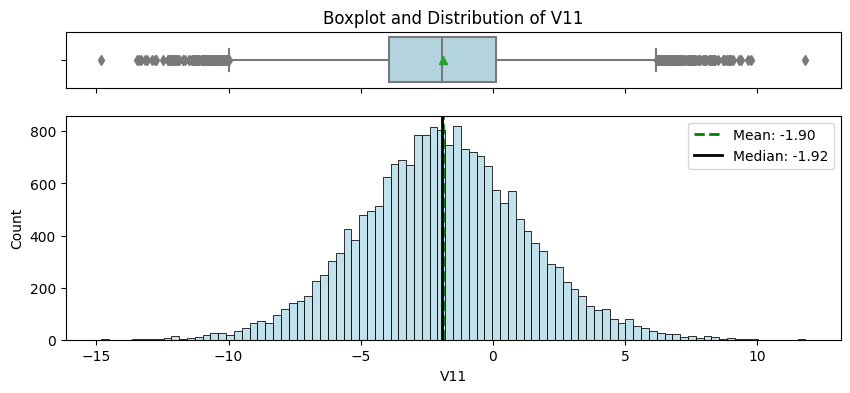

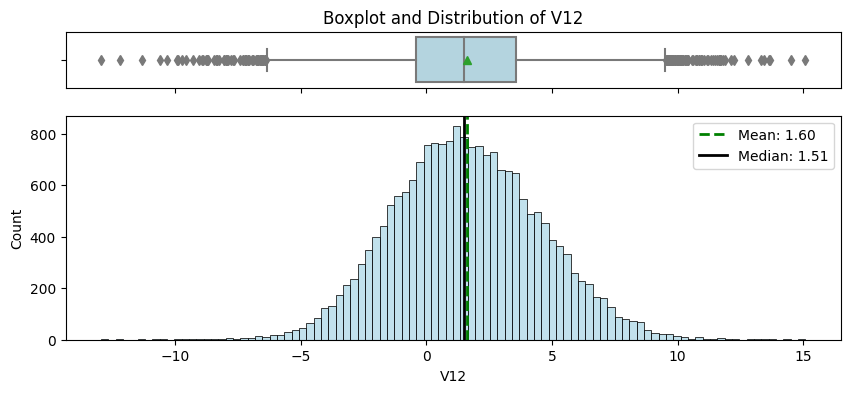

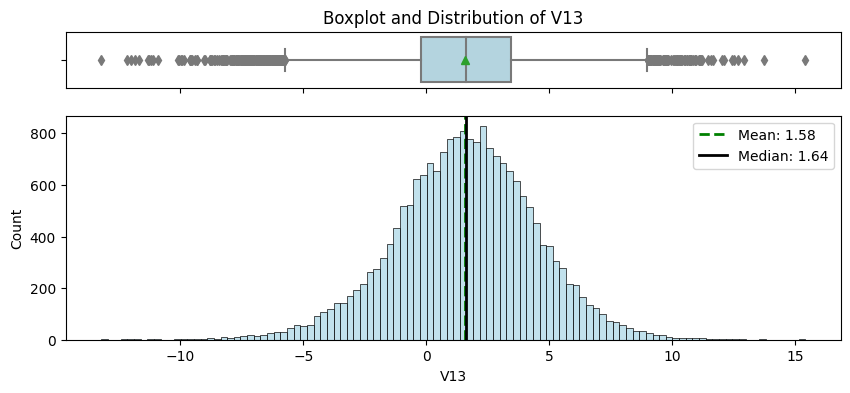

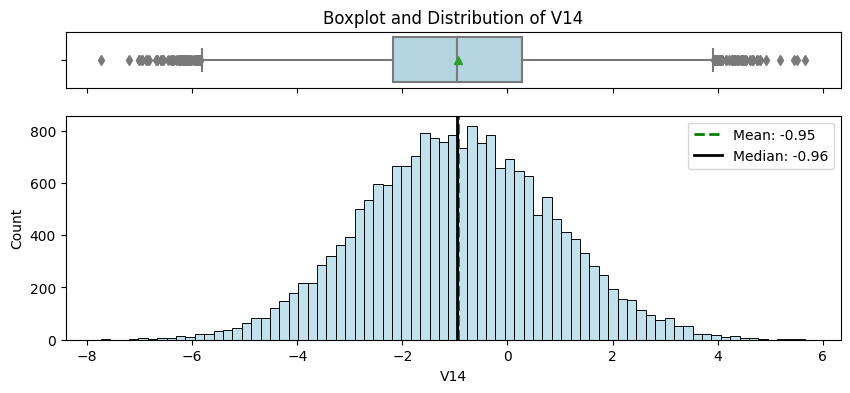

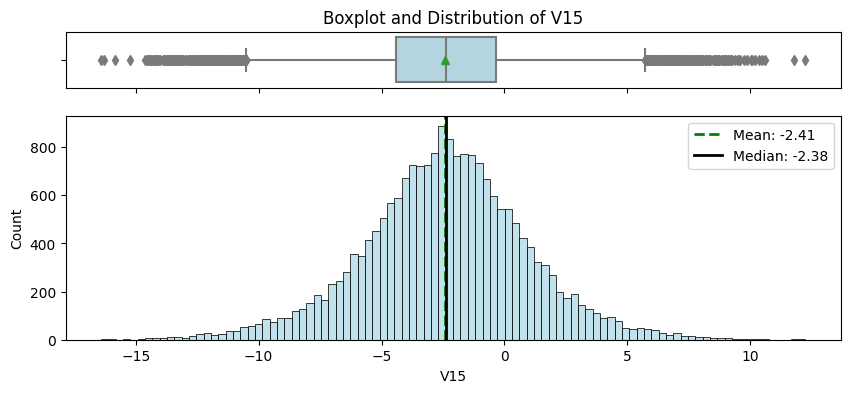

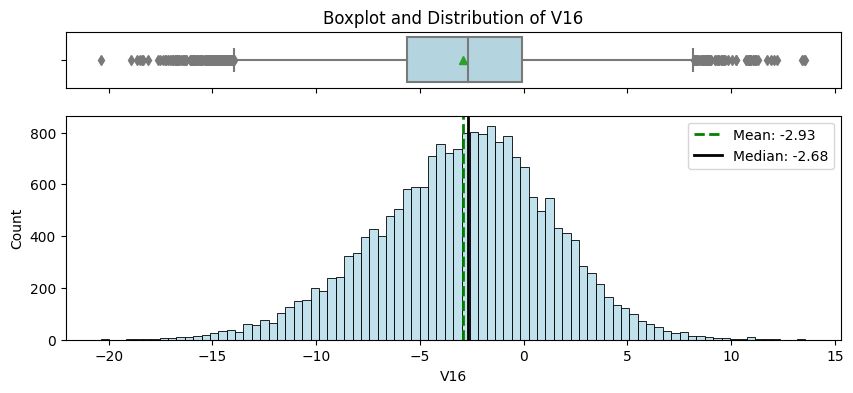

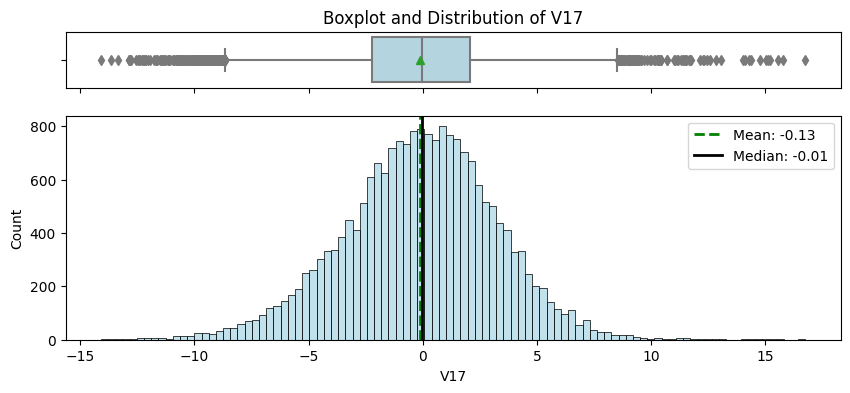

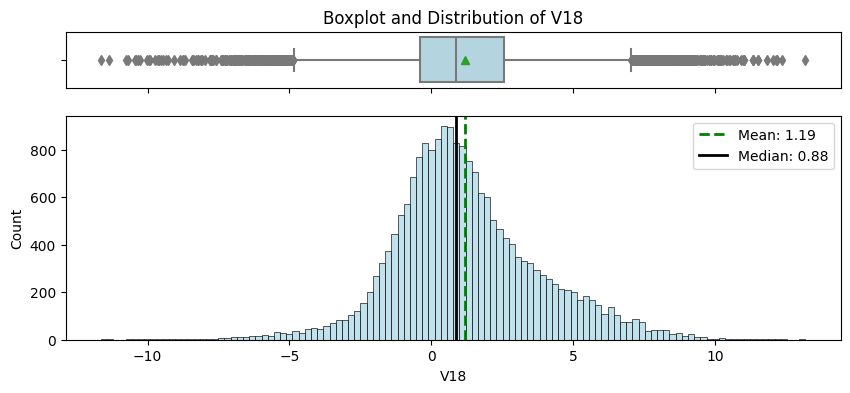

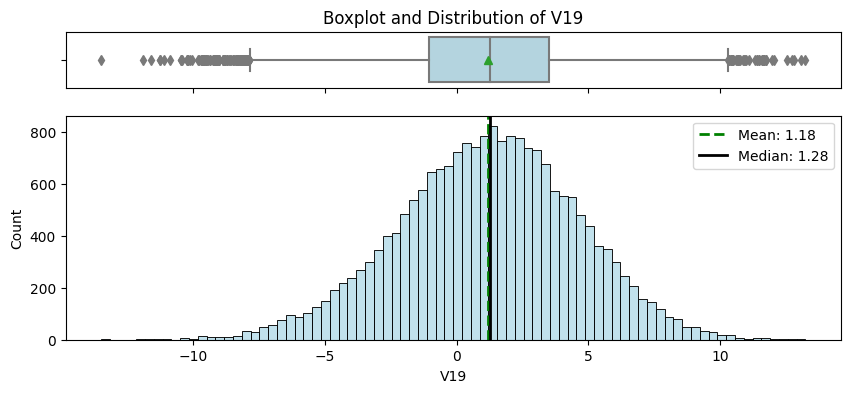

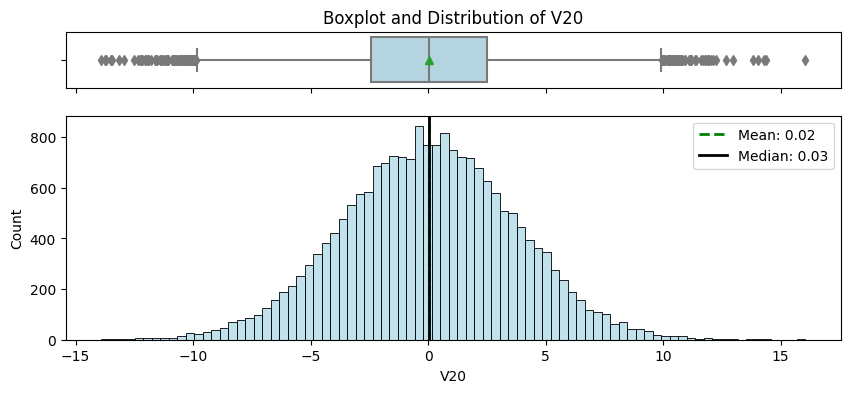

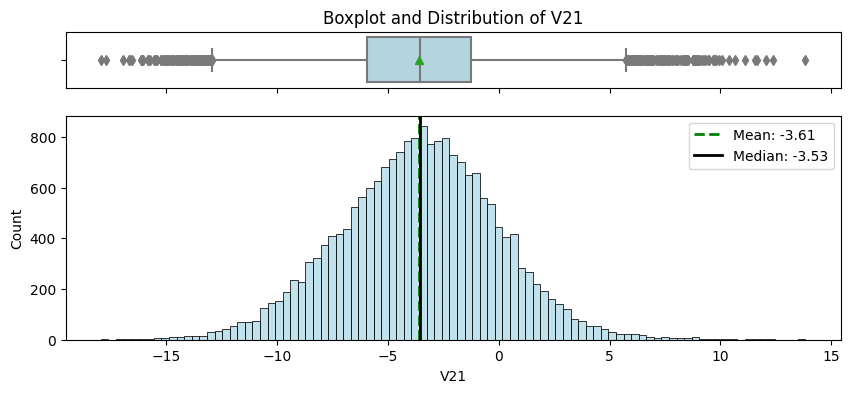

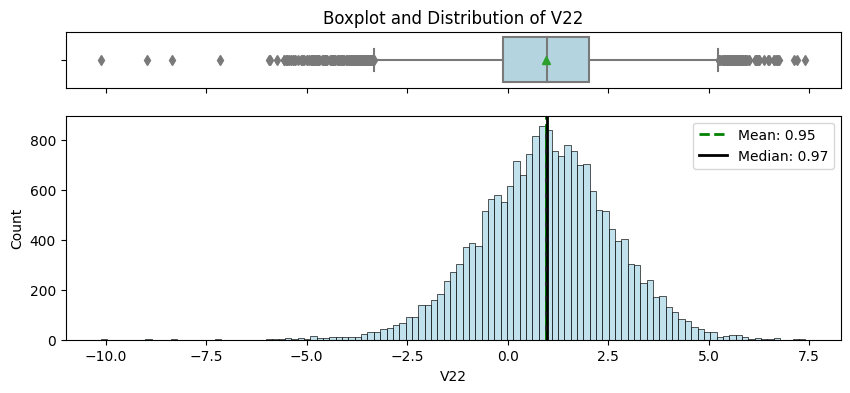

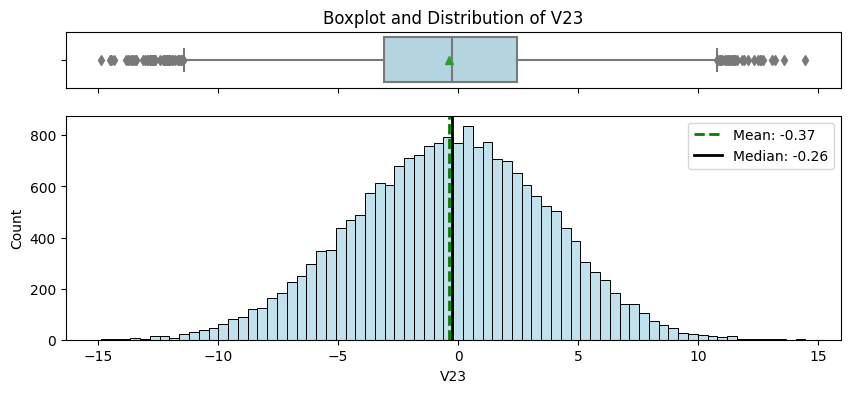

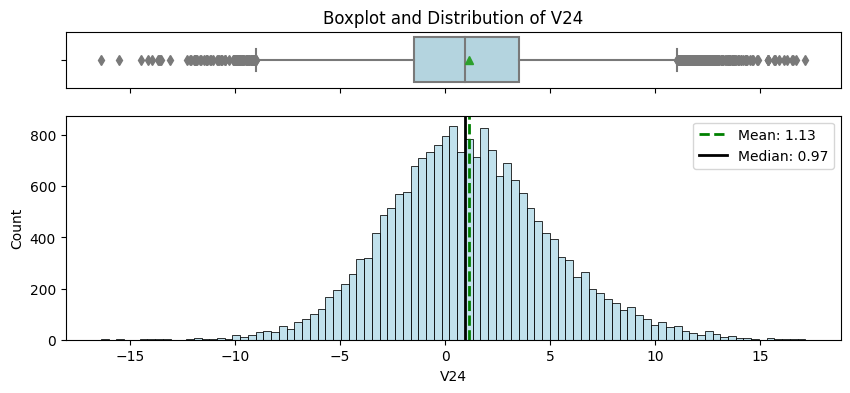

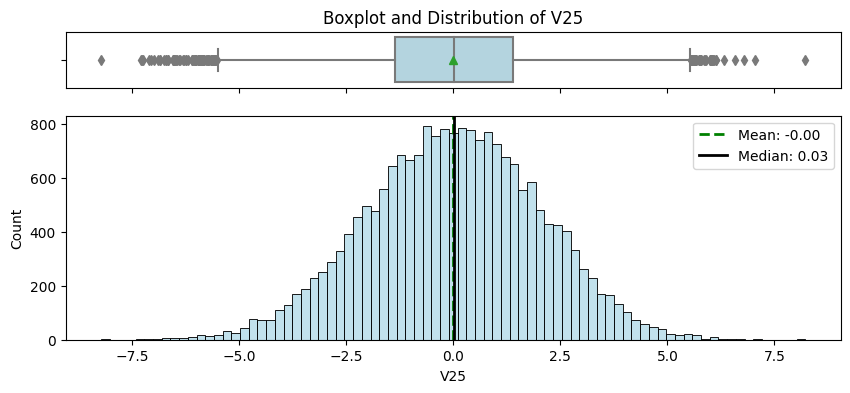

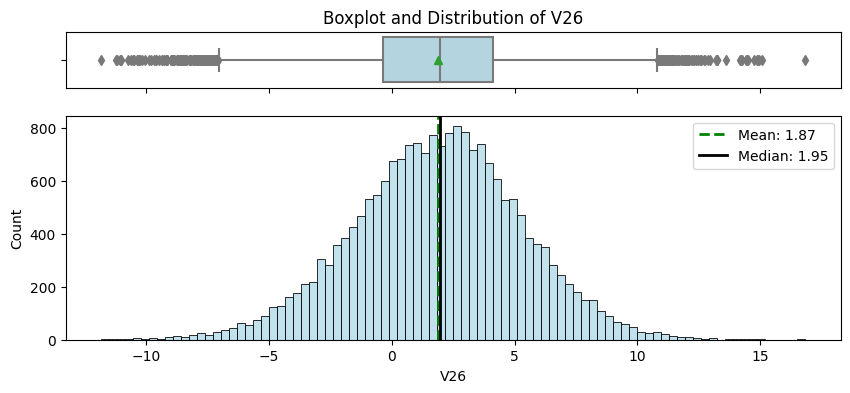

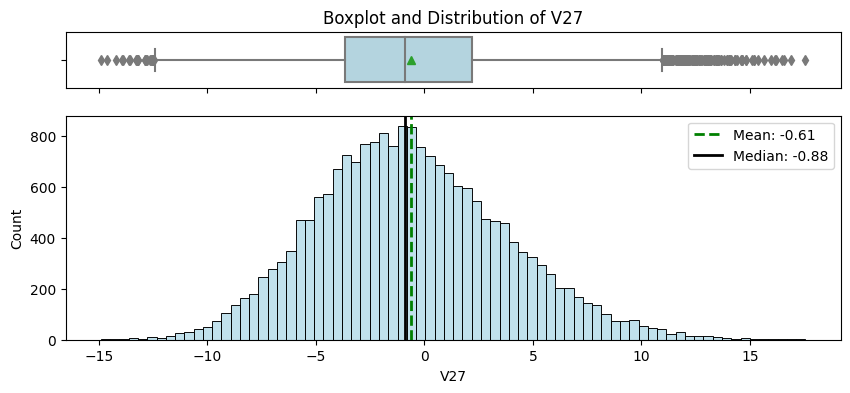

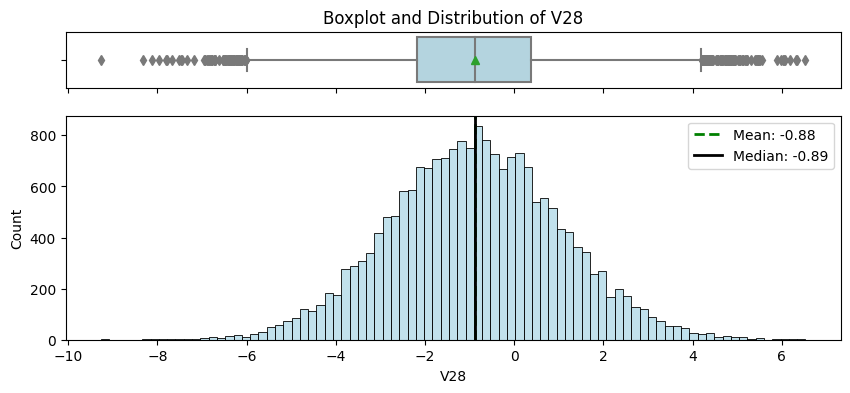

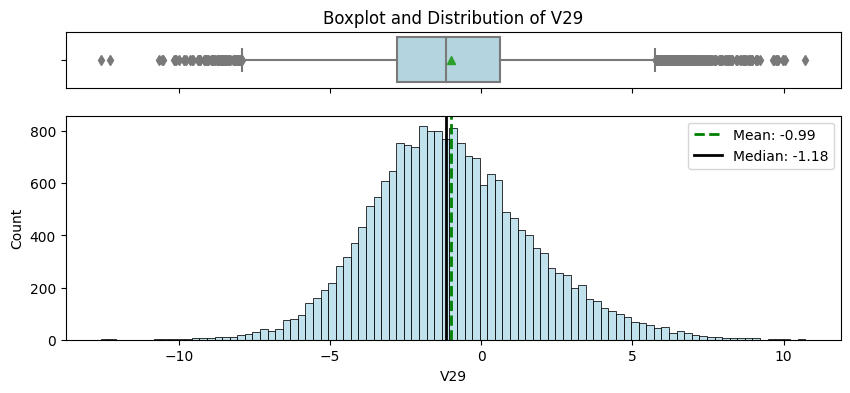

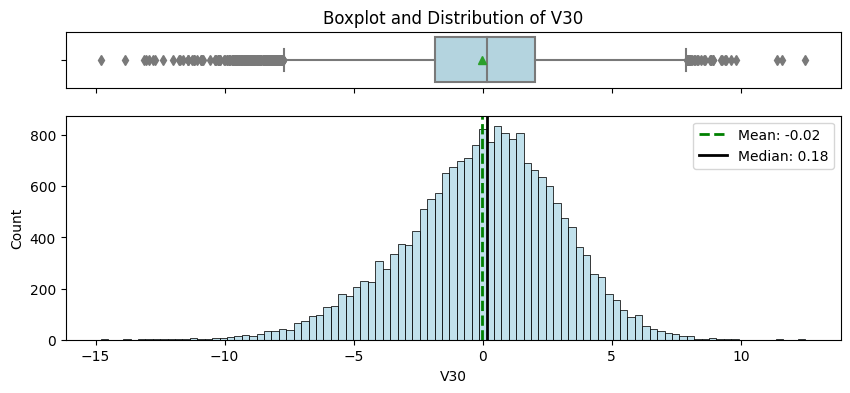

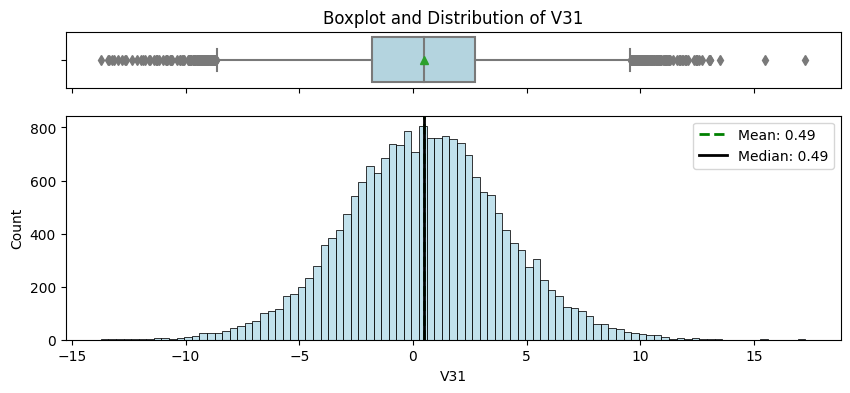

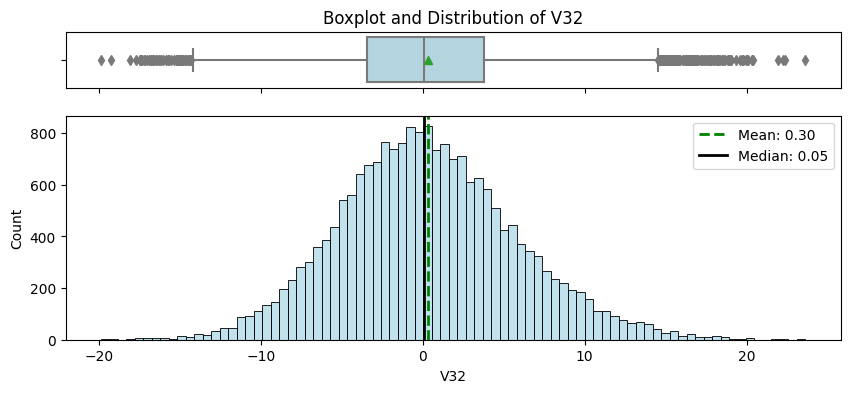

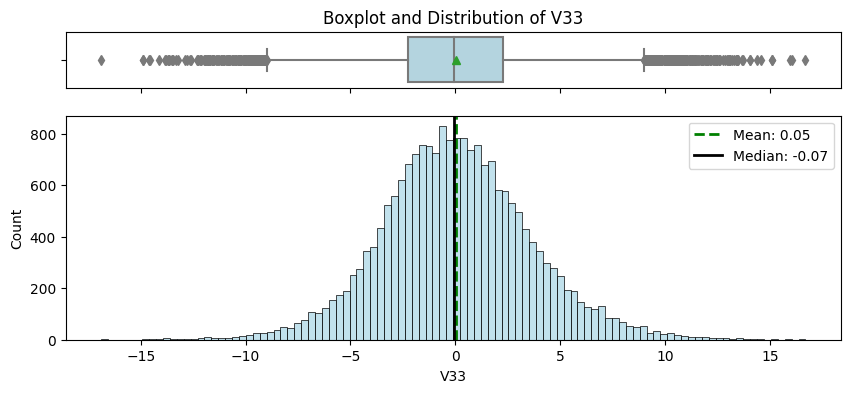

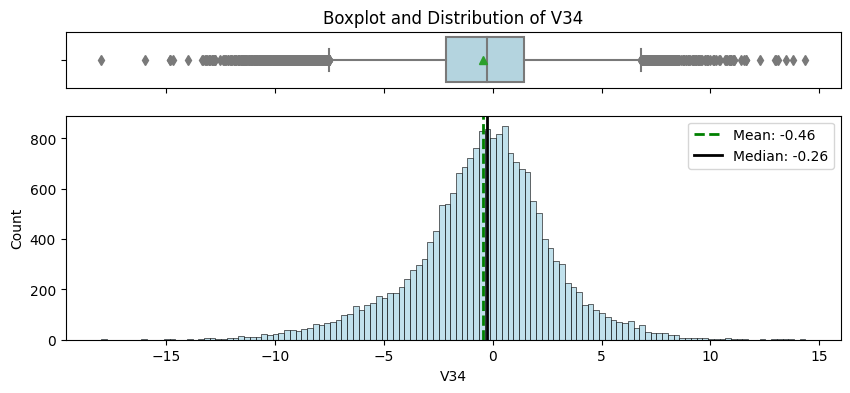

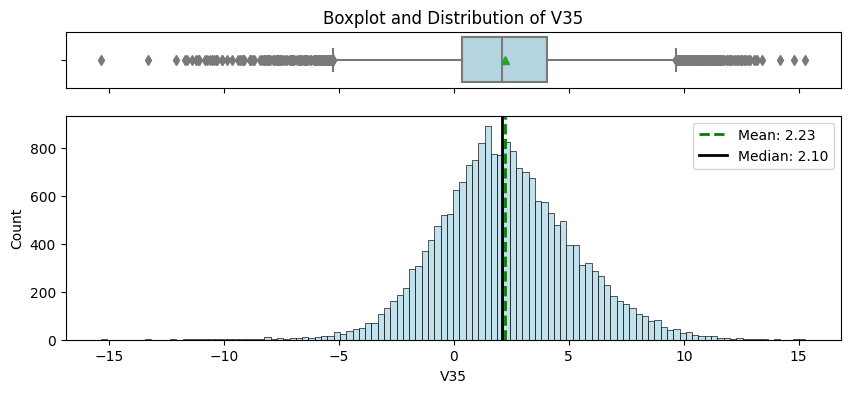

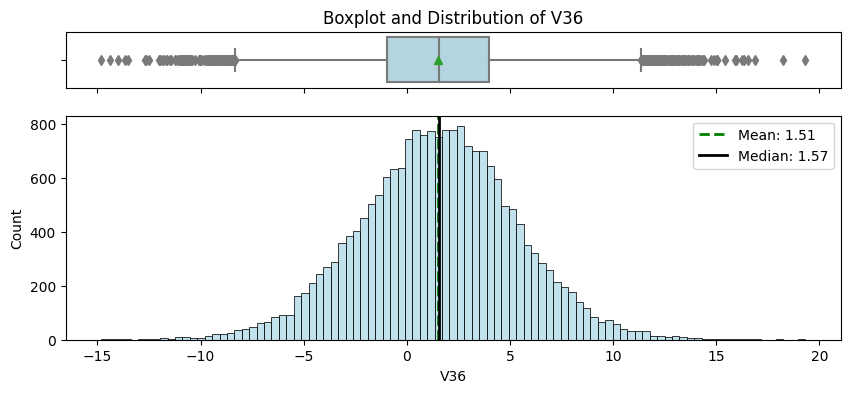

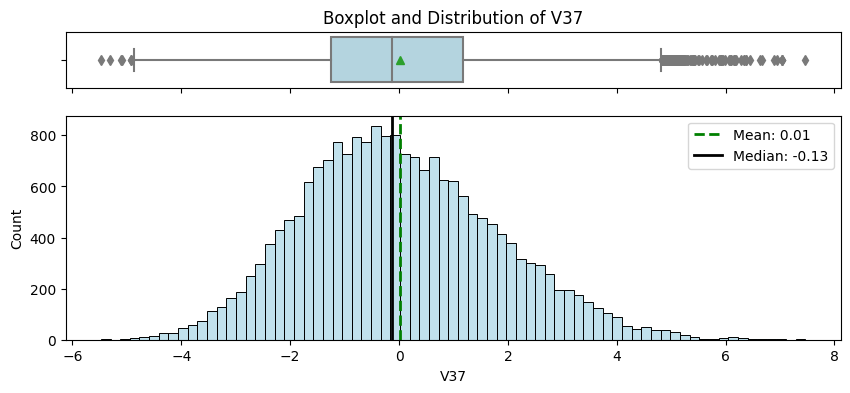

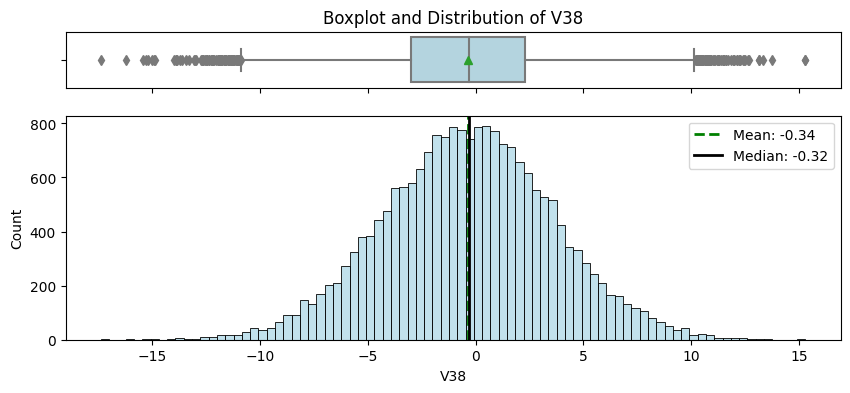

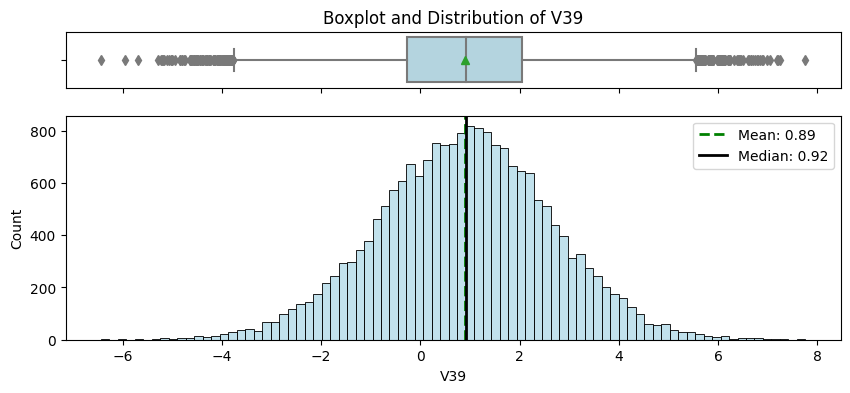

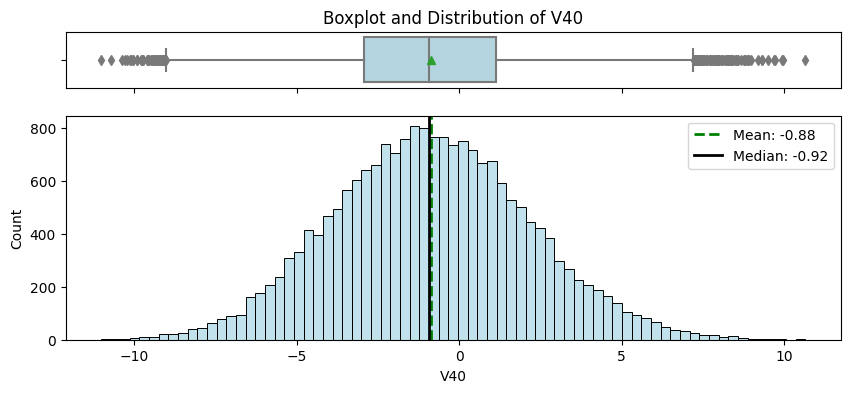

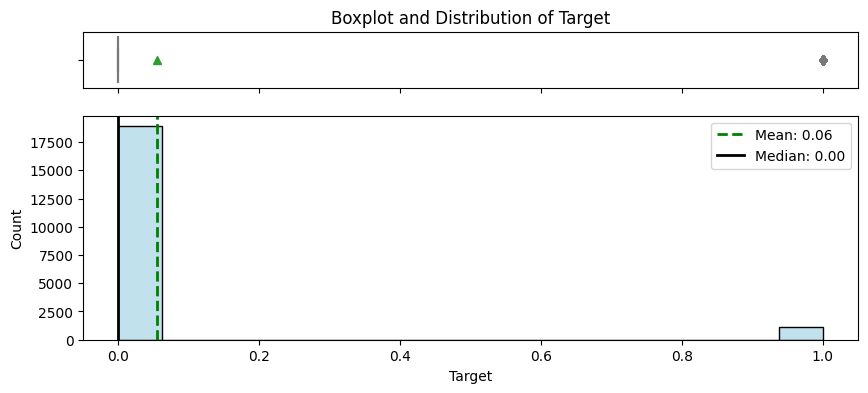

In [21]:
# Looping through the variables in the train dataset and creating a histogram and boxplot for each variable
for variable in train_data.columns:
    hist_and_boxplot(train_data, variable, figsize=(10, 4), kde=False, bins=None)

Observations: 

**Independent variables**: 
- The histograms indicate that the data for these variables is approximately normally distributed with mean and median fairly close for most, further suggesting a normal distribution. 
- The boxplots show dots outside of the whiskers, which represent outliers. These are observations that fall significantly higher or lower than the majority of the data.

**The target variable**:
- Highly imbalanced, with a much larger count of the 0 class compared to the 1 class consistnat with the numerical class distribution observation noted earlier. 

## Bivariate Analysis 

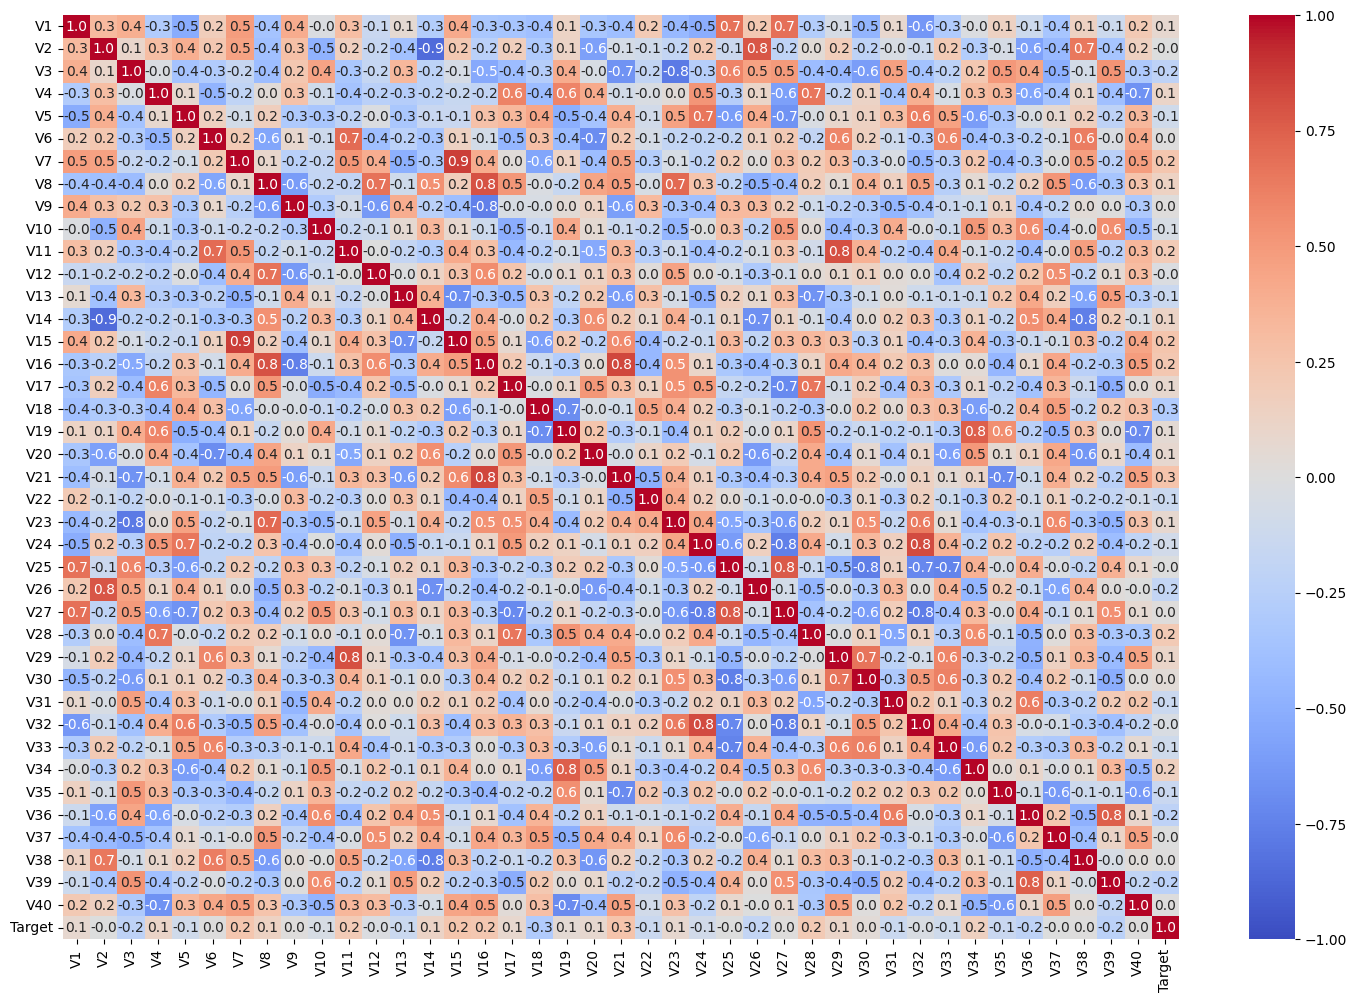

In [22]:
# Heatmap of the correlation coefficients between numerical variables in the dataset
cols_list = train_data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(18, 12))
sns.heatmap(
    train_data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".1f", cmap="coolwarm"
)
plt.show()

Observations:

- Highly Correlated Features:lots of them (both positive and negative). These may represent redundancy within the dataset which means that one feature can be predicted from the other with a high degree of accuracy. In other words, these features carry similar information or signals about the data. 
  - Multicollinearity in liner models
  - Overfitting the ti the training dataset due to redundant features 
  - Redundant features increase computational complexity 
  - Consider dimensionality reduction techniques like PCA

- Relationship with Target: features that have a stronger correlation with the target variable (V18, V21). These features may be particularly important for predicting the target and should be examined more closely in subsequent analyses.

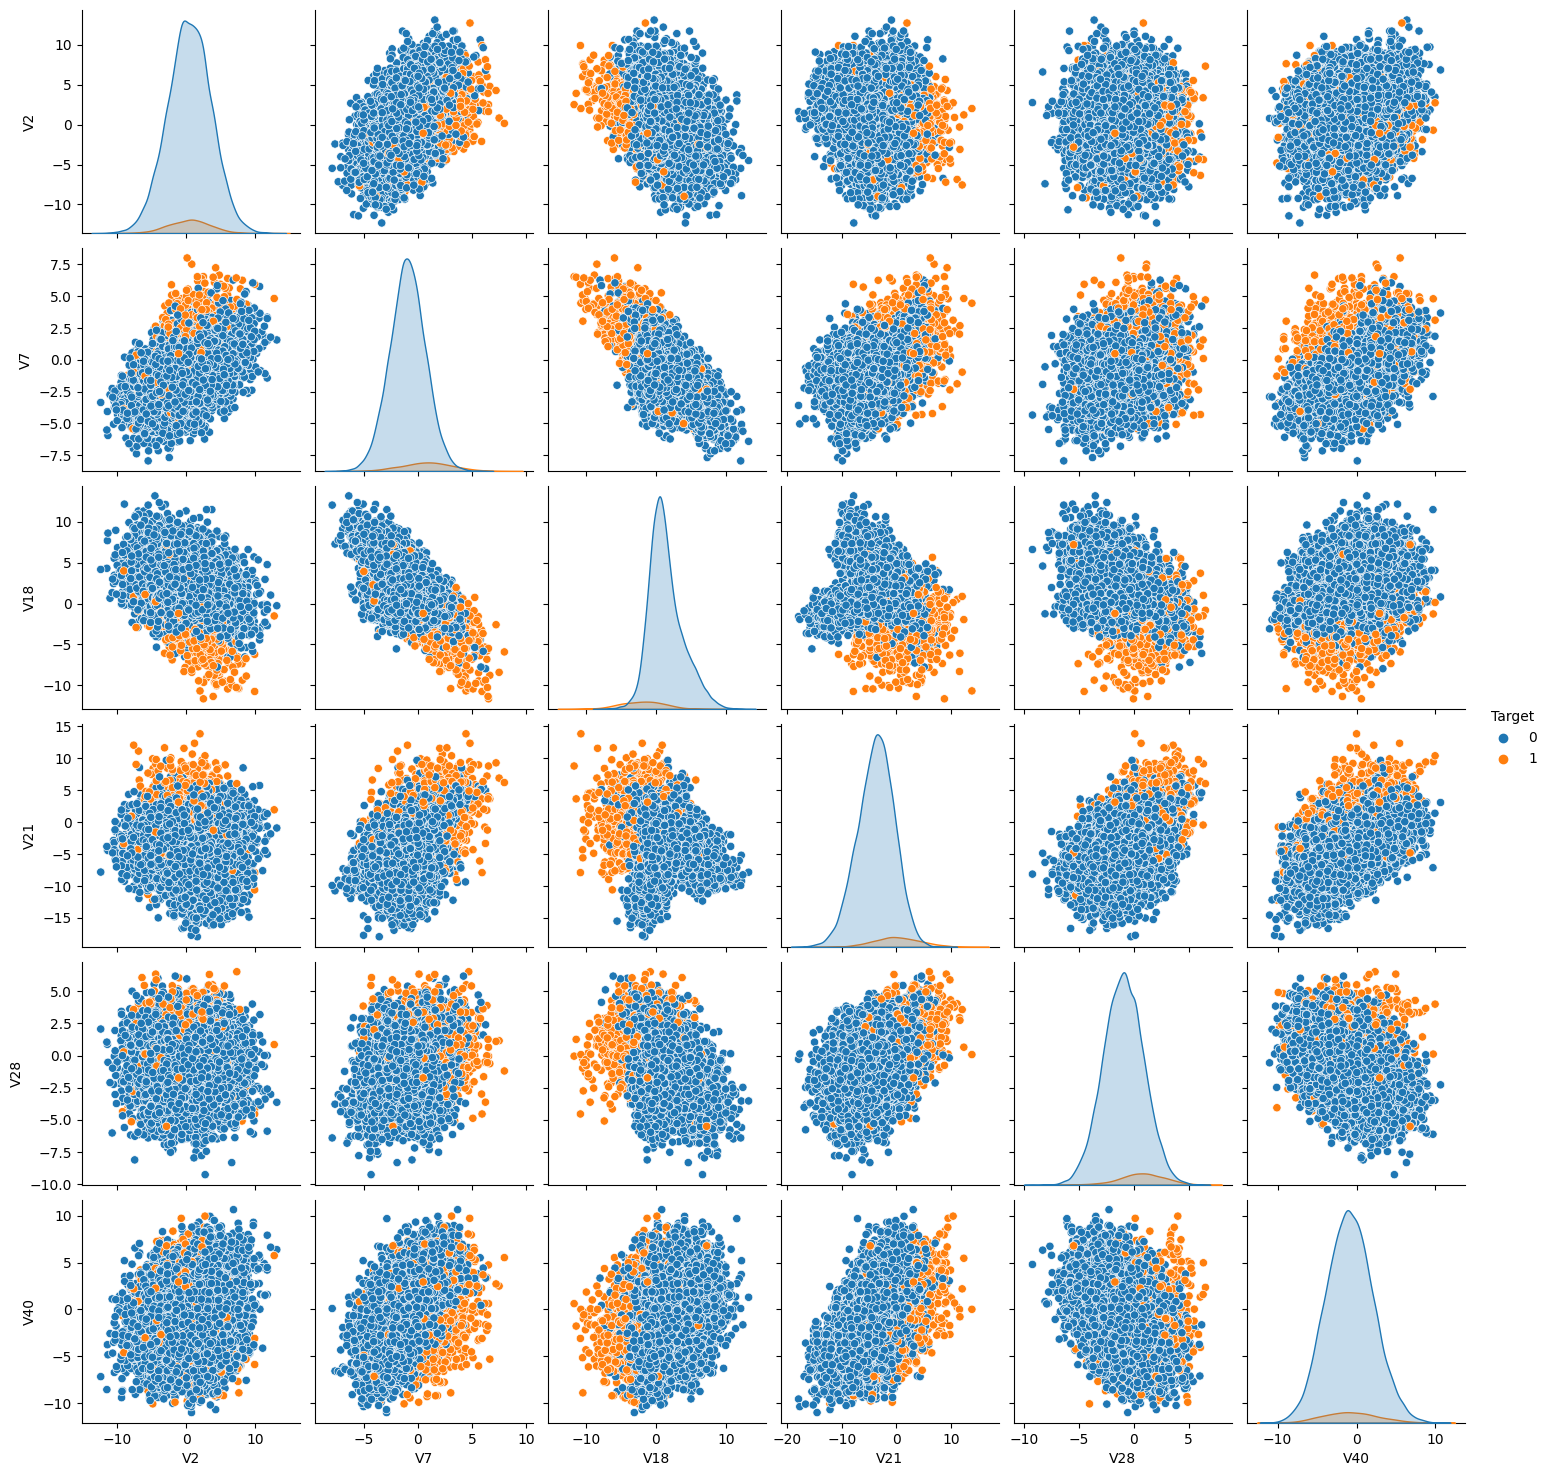

In [23]:
# Selected a subset of features for the pair plot for better performance and clarity
selected_features = ['V2', 'V7', 'V18', 'V21', 'V28', 'V40', 'Target']

# Create the pair plot using the selected features
sns.pairplot(train_data[selected_features], hue='Target', diag_kind='kde')
plt.show()

In [26]:
train_df = train_data.copy()
test_df = test_data.copy()

# Data Pre-Processing 

In [27]:
# Split train data into X and y to separate the features from the target
X = train_df.drop(["Target"], axis=1)
y = train_df["Target"]

In [28]:
# Split the X training set into train and validate
X_train_, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y_train)

In [48]:
# Check the number of rows and columns in the X_train data
X_train.shape

(15000, 40)

In [31]:
# Check the number of rows and columns in the X_val data
X_val.shape

(5000, 40)

In [30]:
# Split test data into X and y to separate the features from the target
X_test = test_df.drop(["Target"], axis=1)
y_test = test_df["Target"]

In [32]:
# Check the number of rows and columns in the X_test data
X_test.shape

(5000, 40)

- X_train and y_train are now the subsets for training the model.
- X_val and y_val are for validating the model during the hyperparameter tuning and model selection process.
- X_test and y_test (from the original test dataset) are used strictly for the final evaluation of the model to assess its performance on unseen data.

### Missing Value Imputation

In [33]:
# Create an instance of the imputer
imputer = SimpleImputer(strategy="median")

In [41]:
# Fit on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data based on the fit from the training data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# Transform the test data based on the fit from the training data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [42]:
# Check that it worked
print(X_train.isna().sum())
print("-"*15)
print(X_val.isna().sum())
print("-"*15)
print(X_test.isna().sum())
print("-"*15)

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
---------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
---------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25   

###  Scale/Normalize Features 

In [43]:
# Create a scaler instance
scaler = StandardScaler()

In [44]:
# Fit on the training data and transform it
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Transform the validation and test data
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Model Building

In [45]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    TP = confusion_matrix(target, model.predict(predictors))[1,1]
    FP = confusion_matrix(target, model.predict(predictors))[0,1]
    FN = confusion_matrix(target, model.predict(predictors))[1,0]
    
    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

### Defining scorer for cross-validation and hyperparameter tuning

- The goal heare is to reduce FN and maximize "Recall"
- So, use Recall as a scorer 

In [46]:
# Defining the scorer based on recall
scorer = metrics.make_scorer(metrics.recall_score)

## Model Building on Original Data

In [50]:
# Models to evaluate
models = []
models.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
models.append(("RandomForest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoosting", GradientBoostingClassifier(random_state=1)))
models.append(("BaggingClassifier", BaggingClassifier(random_state=1)))
models.append(("LogisticRegression", LogisticRegression(random_state=1, max_iter=10000)))  # Increased max_iter for convergence

results_original = []  # To store cross-validation results
names_original = []  # To store model names

# Cross-validation across all models for Original Data
print("\nCross-Validation on Original Data:\n")


# StratifiedKFold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Cross-validation across all models
for name, model in models:
    cv_result = cross_val_score(model, X_train, y_train, scoring=scorer, cv=kfold)
    results_original.append(cv_result)
    names_original.append(name)
    print(f"{name}: Mean Recall Score = {cv_result.mean()}")


print("\nValidation Performance on Original Data:\n")

# Fit models on the original training set and evaluate on the original validation set
for name, model in models:
    model.fit(X_train, y_train)  # Use the training data
    scores = recall_score(y_val, model.predict(X_val))  # Evaluate against the validation set
    print(f"{name}: Validation Recall Score = {scores}")


Cross-Validation on Original Data:

DecisionTree: Mean Recall Score = 0.7251857730322487
RandomForest: Mean Recall Score = 0.7179712863429767
AdaBoost: Mean Recall Score = 0.600266936007503
GradientBoosting: Mean Recall Score = 0.6842940624774547
BaggingClassifier: Mean Recall Score = 0.6975759324724046
LogisticRegression: Mean Recall Score = 0.4898780751749513

Validation Performance on Original Data:

DecisionTree: Validation Recall Score = 0.6137184115523465
RandomForest: Validation Recall Score = 0.7833935018050542
AdaBoost: Validation Recall Score = 0.4693140794223827
GradientBoosting: Validation Recall Score = 0.8483754512635379
BaggingClassifier: Validation Recall Score = 0.5776173285198556
LogisticRegression: Validation Recall Score = 0.4981949458483754


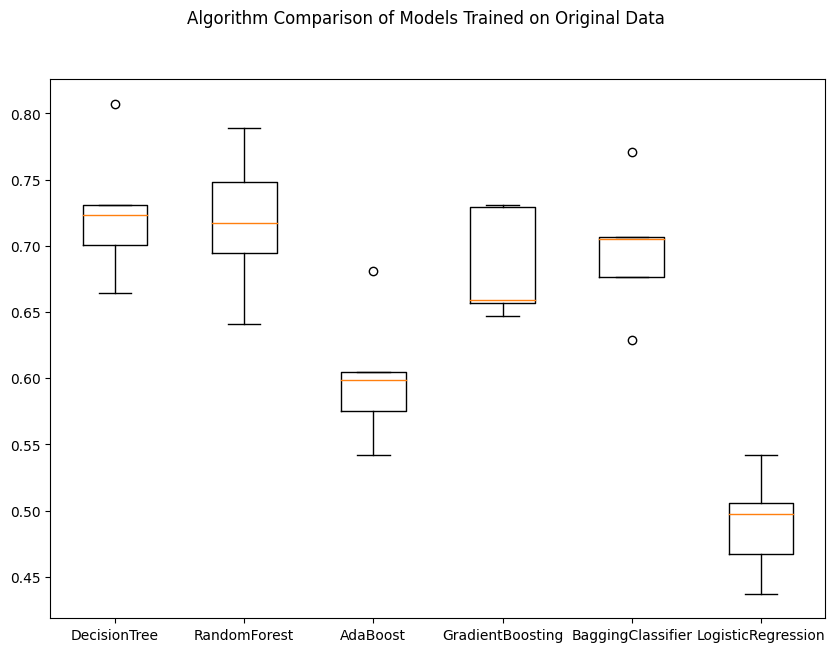

In [51]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison of Models Trained on Original Data")
ax = fig.add_subplot(111)

plt.boxplot(results_original)
ax.set_xticklabels(names_original)

plt.show()

Recall is highest for Random Forest followed by Decision Tree and Gradient Boosting.

## Model Building with Oversampled Data

In [52]:
# Fit Synthetic Minority Over Sampling Technique (SMOTE) on train data, which uses kNN to generate the data
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [53]:
print("Before OverSampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After OverSampling, count of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, count of label '0': {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, count of label '1': 833
Before OverSampling, count of label '0': 14167 

After OverSampling, count of label '1': 14167
After OverSampling, count of label '0': 14167 

After OverSampling, the shape of train_X: (28334, 40)
After OverSampling, the shape of train_y: (28334,) 



Observations:

SMOTE has successfully balanced your dataset by generating synthetic examples of the minority class (1) using k-nearest neighbors.

Before applying SMOTE: the training dataset was significantly imbalanced with only 833 instances of the minority class (1) compared to 14,167 instances of the majority class (0). This imbalance leads to models that are biased towards the majority class and ignoring the minority class which is of greater interest to us.

After applying SMOTE: both classes now have an equal count of 14,167 instances, doubling the size of the training dataset to 28,334 instances. This balanced dataset is expected to improve model performance on the minority class by providing it with more examples to learn from, thus helping the model to generalize better and be less biased towards the majority class.

In [54]:
# Models to evaluate on Oversampled Data
models = []
models.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
models.append(("RandomForest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoosting", GradientBoostingClassifier(random_state=1)))
models.append(("BaggingClassifier", BaggingClassifier(random_state=1)))
models.append(("LogisticRegression", LogisticRegression(random_state=1, max_iter=10000)))  # Increased max_iter for convergence

# To store cross-validation results
results_oversampled = []
# To store model names
names_oversampled= []

# Cross-validation across all models for Oversampled Data
print("\nCross-Validation on Oversampled Data:\n")

# StratifiedKFold setup
kfold_oversampled = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Cross-validation across all models
for name, model in models:
    cv_result_oversampled = cross_val_score(model, X_train_over, y_train_over, scoring=scorer, cv=kfold_oversampled)
    results_oversampled.append(cv_result_oversampled)
    names_oversampled.append(name)
    print(f"{name}: Mean Recall Score = {cv_result_oversampled.mean()}")

print("\nValidation Performance on Oversampled Data:\n")

# Fit models on the oversampled training set and evaluate on the original validation set
for name, model in models:
    model.fit(X_train_over, y_train_over)  # Use the oversampled training data
    scores_oversampled = recall_score(y_val, model.predict(X_val))  # Evaluate against the validation set
    print(f"{name}: Validation Recall Score = {scores_oversampled}")


Cross-Validation on Oversampled Data:

DecisionTree: Mean Recall Score = 0.9690118302763503
RandomForest: Mean Recall Score = 0.9833415081503631
AdaBoost: Mean Recall Score = 0.8947543083444662
GradientBoosting: Mean Recall Score = 0.9233426689826849
BaggingClassifier: Mean Recall Score = 0.9740237362808178
LogisticRegression: Mean Recall Score = 0.8762613028574162

Validation Performance on Oversampled Data:

DecisionTree: Validation Recall Score = 0.44404332129963897
RandomForest: Validation Recall Score = 0.41155234657039713
AdaBoost: Validation Recall Score = 0.48375451263537905
GradientBoosting: Validation Recall Score = 0.740072202166065
BaggingClassifier: Validation Recall Score = 0.4259927797833935
LogisticRegression: Validation Recall Score = 0.7148014440433214


Observations:

As expected, the balancing of the data with SMOTE improved model performance accross the board. However, it also introduced overfitting issues (ratio of Cross-Validation to Validation scores). Except for AdaBoost and Logistic Regression.

In [ ]:
# Plotting boxplots for CV scores of all models evaluated on oversampled data
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison of Models Trained on Oversampled Data")
ax = fig.add_subplot(111)

plt.boxplot(results_oversampled)
ax.set_xticklabels(names_oversampled)

plt.show()

Observations:

Same trend, jsut more exagerated. 

## Model Building with Undersampled Data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
print("Before Under Sampling, count of label '1': {}".format(sum(y_train== 1)))
print("Before Under Sampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, count of label '1': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, count of label '0': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

In [ ]:
# Models to evaluate on Undersampled Data
models_undersampled = []
models_undersampled.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
models_undersampled.append(("RandomForest", RandomForestClassifier(random_state=1)))
models_undersampled.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models_undersampled.append(("GradientBoosting", GradientBoostingClassifier(random_state=1)))
models_undersampled.append(("BaggingClassifier", BaggingClassifier(random_state=1)))
models_undersampled.append(("LogisticRegression", LogisticRegression(random_state=1, max_iter=10000)))  # Increased max_iter for convergence

# To store cross-validation results for undersampled data
results_undersampled = []
# To store model names for undersampled data
names_undersampled = []

# Cross-validation across all models for Undersampled Data
print("\nCross-Validation on Undersampled Data:\n")

# StratifiedKFold setup for undersampled data
kfold_undersampled = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Cross-validation across all models
for name, model in models_undersampled:
    cv_result_undersampled = cross_val_score(model, X_train_un, y_train_un, scoring=scorer, cv=kfold_undersampled)
    results_undersampled.append(cv_result_undersampled)
    names_undersampled.append(name)
    print(f"{name}: Mean Recall Score = {cv_result_undersampled.mean()}")

print("\nValidation Performance on Undersampled Data:\n")

# Fit models on the undersampled training set and evaluate on the original validation set
for name, model in models_undersampled:
    model.fit(X_train_un, y_train_un)  # Use the undersampled training data
    scores_undersampled = recall_score(y_val, model.predict(X_val))  # Evaluate against the validation set
    print(f"{name}: Validation Recall Score = {scores_undersampled}")

In [ ]:
# Plotting boxplots for CV scores of all models evaluated on  undersampled data
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison of Models Trained on Undersampled Data")
ax = fig.add_subplot(111)

plt.boxplot(results_undersampled)
ax.set_xticklabels(names_undersampled)

plt.show()

Observations:

Fast. Random Forest still highest performace. Less overfitting accross the board. 

## Hyperparameter Tuning 

### Model Selection for Hyperparameter Tuning


Top 3 models providing the highest Recall scores on both cross-validation and validation datasets :

1. **RandomForest**
2. **GradientBoosting**
3. **AdaBoost**

### Hyperparameter Tuning of Random Forest on Original Data

In [ ]:
# Defining the Random Forest model for original data
rf_model_orig = RandomForestClassifier(random_state=1)

# Parameter grid for Random Forest
param_grid_rf_orig = {
    "n_estimators": [200, 250],  # Reduced for simplicity
    "min_samples_leaf": [1, 2],  # Simplified range
    "max_features": ['sqrt'],  # Simplified choice
    "max_samples": [0.5]  # Simplified choice
}

# Setting up RandomizedSearchCV for the original data with reduced n_iter and cv
randomized_rf_orig = RandomizedSearchCV(estimator=rf_model_orig, param_distributions=param_grid_rf_orig,
                                        scoring= scorer, n_iter=10, cv=3, random_state=1)

# Fitting RandomizedSearchCV on the original data
randomized_rf_orig.fit(X_train, y_train)

# Extracting best parameters and creating a new Random Forest Classifier
best_params_rf_orig = randomized_rf_orig.best_params_
tuned_rf_orig = RandomForestClassifier(**best_params_rf_orig, random_state=1)

# Fitting the tuned model and evaluating
tuned_rf_orig.fit(X_train, y_train)

In [ ]:
# Evaluating the tuned model on original data
rf_train_perf_orig = model_performance_classification_sklearn(tuned_rf_orig, X_train, y_train)
print("Performance on Train Set:")
rf_train_perf_orig

In [ ]:
rf_val_perf_orig = model_performance_classification_sklearn(tuned_rf_orig, X_val, y_val)
print("Performance on Validation Set:")
rf_val_perf_orig

### Hyperparameter Tuning of Random Forest on Oversampled Data

In [ ]:
 # Defining the Random Forest model for original data
rf_model_over = RandomForestClassifier(random_state=1)

# Parameter grid for Random Forest
param_grid_rf_orig = {
    "n_estimators": [200, 250],  # Reduced for simplicity
    "min_samples_leaf": [1, 2],  # Simplified range
    "max_features": ['sqrt'],  # Simplified choice
    "max_samples": [0.5]  # Simplified choice
}

# Setting up RandomizedSearchCV for the original data
randomized_rf_over = RandomizedSearchCV(estimator=rf_model_orig, param_distributions=param_grid_rf_orig,
                                        scoring=scorer, n_iter=50, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the oversampled data
randomized_rf_over.fit(X_train_over, y_train_over)

# Extracting best parameters for oversampled data
best_params_rf_over = randomized_rf_over.best_params_

# Creating a new Random Forest Classifier with the best parameters for oversampled data
tuned_rf_over = RandomForestClassifier(**best_params_rf_over, random_state=1)

# Fitting the tuned model on the oversampled training data
tuned_rf_over.fit(X_train_over, y_train_over)

In [ ]:
# Evaluating the tuned model on oversampled train data
rf_train_perf_over = model_performance_classification_sklearn(tuned_rf_over, X_train_over, y_train_over)
rf_train_perf_over

In [ ]:
# Evaluating the tuned model on oversampled validation data
rf_val_perf_over = model_performance_classification_sklearn(tuned_rf_over, X_val, y_val)
rf_val_perf_over

### Hyperparameter Tuning of Random Forest on Undersampled Data

In [ ]:
 # Defining the Random Forest model for original data
rf_model_un = RandomForestClassifier(random_state=1)

# Parameter grid for Random Forest
param_grid_rf_orig = {
    "n_estimators": [200, 250],  # Reduced for simplicity
    "min_samples_leaf": [1, 2],  # Simplified range
    "max_features": ['sqrt'],  # Simplified choice
    "max_samples": [0.5]  # Simplified choice
}

# Setting up RandomizedSearchCV for the original data
randomized_rf_un = RandomizedSearchCV(estimator=rf_model_orig, param_distributions=param_grid_rf_orig,
                                        scoring= scorer, n_iter=50, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the undersampled data
randomized_rf_un.fit(X_train_un, y_train_un)

# Extracting best parameters for undersampled data
best_params_rf_un = randomized_rf_un.best_params_
print("Best parameters are {} with CV score={}:" .format(randomized_rf_un.best_params_,randomized_rf_un.best_score_))

In [ ]:
# Creating a new Random Forest Classifier with the best parameters for undersampled data
tuned_rf_un = RandomForestClassifier(**best_params_rf_un, random_state=1)

# Fitting the tuned model on the undersampled training data
tuned_rf_un.fit(X_train_un, y_train_un)

In [ ]:
# Evaluating the tuned model on undersampled data
rf_train_perf_un = model_performance_classification_sklearn(tuned_rf_un, X_train_un, y_train_un)
rf_train_perf_un

In [ ]:
rf_val_perf_un = model_performance_classification_sklearn(tuned_rf_un, X_val, y_val)
rf_val_perf_un

### Hyperparameter Tuning of Gradient Boost on Original Data

In [ ]:
# Defining the Gradient Boosting model
gb_model_orig = GradientBoostingClassifier(random_state=1)

# Parameter grid remains the same as the oversampling case
param_grid_orig = {
    "n_estimators": np.arange(100, 150, 25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7]
}

# Setting up RandomizedSearchCV for the original data
randomized_cv_orig = RandomizedSearchCV(estimator=gb_model_orig, param_distributions=param_grid_orig,
                                        scoring=scorer, n_iter=50, n_jobs=-1, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the original data
randomized_cv_orig.fit(X_train, y_train)

# Best parameters
# print("Best parameters for original data are {} with CV score={}:".format(randomized_cv_orig.best_params_, randomized_cv_orig.best_score_))

# Extracting best parameters for the original data
best_params_orig = randomized_cv_orig.best_params_

# Creating a new Gradient Boosting Classifier with the best parameters for original data
tuned_gbm_orig = GradientBoostingClassifier(
    max_features=best_params_orig['max_features'],
    random_state=1,
    learning_rate=best_params_orig['learning_rate'],
    n_estimators=best_params_orig['n_estimators'],
    subsample=best_params_orig['subsample']
)

# Fitting the tuned model on the original training data
tuned_gbm_orig.fit(X_train, y_train)

In [ ]:
# Checking performance 
gbm_train_perf_orig = model_performance_classification_sklearn(tuned_gbm_orig, X_train_over, y_train_over)
print("Performance on Train Set:")
gbm_train_perf_orig


In [ ]:
gbm_val_perf_orig = model_performance_classification_sklearn(tuned_gbm_orig, X_val, y_val)
print("Performance on Validation Set:")
gbm_val_perf_orig

### Hyperparameter Tuning of Gradient Boost on Oversampled Data

In [ ]:
# Defining the Gradient Boosting model for oversampled data
gb_model_over = GradientBoostingClassifier(random_state=1)

# Parameter grid for oversampled data (you can adjust or use the same)
param_grid_over = {
    "n_estimators": np.arange(100, 150, 25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7]
}

# Setting up RandomizedSearchCV for the oversampled data
randomized_cv_over = RandomizedSearchCV(estimator=gb_model_over, param_distributions=param_grid_over,
                                        scoring=scorer, n_iter=50, n_jobs=-1, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the oversampled data
randomized_cv_over.fit(X_train_over, y_train_over)

# Extracting best parameters for the oversampled data
best_params_over = randomized_cv_over.best_params_

# Creating a new Gradient Boosting Classifier with the best parameters for oversampled data
tuned_gbm_over = GradientBoostingClassifier(
    max_features=best_params_over['max_features'],
    random_state=1,
    learning_rate=best_params_over['learning_rate'],
    n_estimators=best_params_over['n_estimators'],
    subsample=best_params_over['subsample']
)

# Fitting the tuned model on the oversampled training data
tuned_gbm_over.fit(X_train_over, y_train_over)

In [ ]:
# Checking performance 
gbm_train_perf_over = model_performance_classification_sklearn(tuned_gbm_over, X_train_over, y_train_over)
gbm_train_perf_over

In [ ]:
gbm_val_perf_over = model_performance_classification_sklearn(tuned_gbm_over, X_val, y_val)
gbm_val_perf_over

### Hyperparameter Tuning of Gradient Boost on Undersampled Data

In [ ]:
# Defining the Gradient Boosting model for undersampled data
gb_model_un = GradientBoostingClassifier(random_state=1)

# Parameter grid for undersampled data (you can adjust or use the same)
param_grid_un = {
    "n_estimators": np.arange(100, 150, 25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7]
}

# Setting up RandomizedSearchCV for the undersampled data
randomized_cv_un = RandomizedSearchCV(estimator=gb_model_un, param_distributions=param_grid_un,
                                      scoring=scorer, n_iter=50, n_jobs=-1, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the undersampled data
randomized_cv_un.fit(X_train_un, y_train_un)

# Extracting best parameters for the undersampled data
best_params_un = randomized_cv_un.best_params_

# Creating a new Gradient Boosting Classifier with the best parameters for undersampled data
tuned_gbm_un = GradientBoostingClassifier(
    max_features=best_params_un['max_features'],
    random_state=1,
    learning_rate=best_params_un['learning_rate'],
    n_estimators=best_params_un['n_estimators'],
    subsample=best_params_un['subsample']
)

# Fitting the tuned model on the undersampled training data
tuned_gbm_un.fit(X_train_un, y_train_un)

In [ ]:
# Checking performance 
gbm_train_perf_un = model_performance_classification_sklearn(tuned_gbm_un, X_train_un, y_train_un)
gbm_train_perf_un

In [ ]:
gbm_val_perf_un = model_performance_classification_sklearn(tuned_gbm_un, X_val, y_val)
gbm_val_perf_un

### Hyperparameter Tuning of AdaBoost on Original Data

In [ ]:
# Defining the AdaBoost model for original data
ada_model_orig = AdaBoostClassifier(random_state=1)

# Parameter grid for AdaBoost
param_grid_ada_orig = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=d, random_state=1) for d in [1, 2, 3]]
}


# Setting up RandomizedSearchCV for the original data
randomized_ada_orig = RandomizedSearchCV(estimator=ada_model_orig, param_distributions=param_grid_ada_orig,
                                         scoring= scorer, n_iter=10, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the original data
randomized_ada_orig.fit(X_train, y_train)

# Extracting best parameters
best_params_ada_orig = randomized_ada_orig.best_params_

# Creating a new pipline of AdaBoost Classifier with the best parameters
tuned_ada_orig = AdaBoostClassifier(**best_params_ada_orig, random_state=1)

# Fitting the tuned model on the original training data
tuned_ada_orig.fit(X_train, y_train)

In [ ]:
# Evaluating the tuned model
ada_train_perf_orig = model_performance_classification_sklearn(tuned_ada_orig, X_train, y_train)
ada_train_perf_orig

In [ ]:
ada_val_perf_orig = model_performance_classification_sklearn(tuned_ada_orig, X_val, y_val)
ada_val_perf_orig

### Hyperparameter Tuning of AdaBoost on Oversample Data

In [ ]:
# Defining the AdaBoost model for oversampled data
ada_model_over = AdaBoostClassifier(random_state=1)

# Parameter grid for AdaBoost
param_grid_ada_over = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=d, random_state=1) for d in [1, 2, 3]]
}
# Setting up RandomizedSearchCV for the oversampled data
randomized_ada_over = RandomizedSearchCV(estimator=ada_model_orig, param_distributions=param_grid_ada_orig,
                                         scoring=scorer, n_iter=10, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the oversampled data
randomized_ada_over.fit(X_train_over, y_train_over)

# Extracting best parameters for the oversampled data
best_params_ada_over = randomized_ada_over.best_params_

# Creating a new AdaBoost Classifier with the best parameters for oversampled data
tuned_ada_over = AdaBoostClassifier(**best_params_ada_over, random_state=1)

# Fitting the tuned model on the oversampled training data
tuned_ada_over.fit(X_train_over, y_train_over)

In [ ]:
print("Best parameters are {} with CV score={}:" .format(randomized_ada_over.best_params_,randomized_ada_over.best_score_))

In [ ]:
# Evaluating the tuned model on oversampled data
ada_train_perf_over = model_performance_classification_sklearn(tuned_ada_over, X_train_over, y_train_over)
ada_train_perf_over

In [ ]:
ada_val_perf_over = model_performance_classification_sklearn(tuned_ada_over, X_val, y_val)
ada_val_perf_over

### Hyperparameter Tuning of AdaBoost on Undersampled Data

In [ ]:
# Defining the AdaBoost model for oversampled data
ada_model_un = AdaBoostClassifier(random_state=1)

# Parameter grid for AdaBoost
param_grid_ada_un = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=d, random_state=1) for d in [1, 2, 3]]
}
# Setting up RandomizedSearchCV for the undersampled data
randomized_ada_un = RandomizedSearchCV(estimator=ada_model_orig, param_distributions=param_grid_ada_orig,
                                       scoring=scorer, n_iter=10, cv=5, random_state=1)

# Fitting RandomizedSearchCV on the undersampled data
randomized_ada_un.fit(X_train_un, y_train_un)

# Extracting best parameters for the undersampled data
best_params_ada_un = randomized_ada_un.best_params_

# Creating a new AdaBoost Classifier with the best parameters for undersampled data
tuned_ada_un = AdaBoostClassifier(**best_params_ada_un, random_state=1)

# Fitting the tuned model on the undersampled training data
tuned_ada_un.fit(X_train_un, y_train_un)

In [ ]:
# Evaluating the tuned model on undersampled data
ada_train_perf_un = model_performance_classification_sklearn(tuned_ada_un, X_train_un, y_train_un)
ada_train_perf_un

In [ ]:
ada_val_perf_un = model_performance_classification_sklearn(tuned_ada_un, X_val, y_val)
ada_val_perf_un

# Model Performance Comparison

In [ ]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_train_perf_orig.T,
        gbm_train_perf_orig.T,
        ada_train_perf_orig.T,
        
        rf_train_perf_over.T,
        gbm_train_perf_over.T,
        ada_train_perf_over.T,

        rf_train_perf_un.T,  
        gbm_train_perf_un.T,
        ada_train_perf_un.T,
    
    ],
    axis=1,
)
models_train_comp_df.columns = [
       'rf_train_perf_orig',
       'gbm_train_perf_orig',
       'ada_train_perf_orig',
    
       'rf_train_perf_over',
       'gbm_train_perf_over',
       'ada_train_perf_over',
     
       'rf_train_perf_un',
       'gbm_train_perf_un',
       'ada_train_perf_un',
]
print("Training performance comparison:")
models_train_comp_df

In [ ]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        rf_val_perf_orig.T,
        gbm_val_perf_orig.T,
        ada_val_perf_orig.T,
        
        rf_val_perf_over.T,
        gbm_val_perf_over.T,
        ada_val_perf_over.T,

        rf_val_perf_un.T,  
        gbm_val_perf_un.T,
        ada_val_perf_un.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
       'rf_val_perf_orig',
       'gbm_val_perf_orig',
       'ada_val_perf_orig',
    
       'rf_val_perf_over',
       'gbm_val_perf_over',
       'ada_val_perf_over',
     
       'rf_val_perf_un',
       'gbm_val_perf_un',
       'ada_val_perf_un',
]
print("Validation performance comparison:")
models_val_comp_df

In [ ]:
print("Training performance comparison:")
models_train_comp_df

In [ ]:
print("Validation performance comparison:")
models_val_comp_df

AdaBoost on oversampled data emerges as a strong candidate for the final model due to its excellent performance across accuracy, **recall**, precision, and F1 score in the validation set.

# Final Model Selection

In [ ]:
# Check the performance of the final model on the test data
ada_test = model_performance_classification_sklearn(tuned_ada_over, X_test, y_test)
ada_test

In [ ]:
feature_names = X_train.columns
importances = tuned_ada_over.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Pipelines to build the final model

Since we have only one datatype in the data we don't need to use column transofrmer which can be used to personalize the pipeline to perform different preprocessing steps on different columns. Note: see case study how to use this.

The steps followed in implementing a pipeline are - 

- Pipeline() - A pipeline is defined as a list of tuples 
- Pipeline.fit() - Pipeline is fitted on the train set
- Pipeline.score() - Pipeline objects checks the performance.

In [14]:
pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("AdaBoost", AdaBoostClassifier
         (
               n_estimators= 50, 
               learning_rate= 0.05,
               base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1),
            ),
        ),
    ]
)

In [19]:
# Check pipline steps 
pipe.steps

[('imputer', SimpleImputer(strategy='median')),
 ('scaler', StandardScaler()),
 ('AdaBoost',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                           random_state=1),
                     learning_rate=0.05))]

In [15]:
# Fit the pipeline on training data as if it were a model since the model is included in it
pipe.fit(X_train, y_train)
# See pipeline structure below

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('AdaBoost',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          random_state=1),
                                    learning_rate=0.05))])

The above means a model is built which becomes part of pipe

In [17]:
# pipe object's accuracy on the train set
pipe.score(X_train, y_train)

0.9777

Instead of model.score calling pipe.score fucntion does a predict then uses those results with the actual results to give the score.

In [18]:
# pipe object's accuracy on the test set
pipe.score(X_test, y_test)

0.9586

The data called by pipe.score() undergoes transformation process in the first two steps (imputer and scaler) and the predict unction in the 3rd step ("AdaBoost").

Questions I still have:
- Am I suppose to fit the pipeline into the X_train, y_train or X and y? 
- What about X_train_over, y_train_over?
- Is SMOTE incorporated into the pipeline? 


# Business Insights and Conclusions

Features V18, V39, and V12 have significant influence on the model's predictions.

The company can focus on further analyzing these important features to better understand their underlying relationships with the target variable.